In [86]:
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from skimage import exposure
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
import numpy as np
from tqdm import tqdm
from skimage.measure import regionprops, regionprops_table
from sklearn.model_selection import ParameterGrid
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *

from ome_types.model import OME, Image, Pixels, Channel
from scipy import stats
import matplotlib.pyplot as plt
import multiprocessing
from matplotlib.colors import ListedColormap
from pyHisto import io, utils

## Image Loading

In [2]:
INPUT = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"

OUTPUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"

In [3]:
SCENE_IDX=1
CH_IDX=1
SUBSAMPLE=10
TAIL=5

In [81]:
img_aics = AICSImage(INPUT)
img_aics.set_scene(SCENE_IDX)
img_dask = img_aics.get_image_dask_data("CYX")
img = img_dask[CH_IDX,:,:].compute()
img.shape

(11289, 12363)

### Normalization

In [5]:
img_subsampled = img[::SUBSAMPLE,::SUBSAMPLE]
pl, pu = np.percentile(np.ravel(img_subsampled[img_subsampled >= 1200]), (TAIL, 100-TAIL))

if not isinstance(pl, (int,float)):
    pl = pl.compute()
if not isinstance(pu, (int,float)):
    pu = pu.compute()

print("Percentiles: ({:.2f},{:.2f})".format(pl,pu))

Percentiles: (1428.00,10203.00)


In [6]:
print("Rescaling image intensity...")
frame_rescaled = exposure.rescale_intensity(img, in_range=(pl, pu),out_range=(0,1))

Rescaling image intensity...


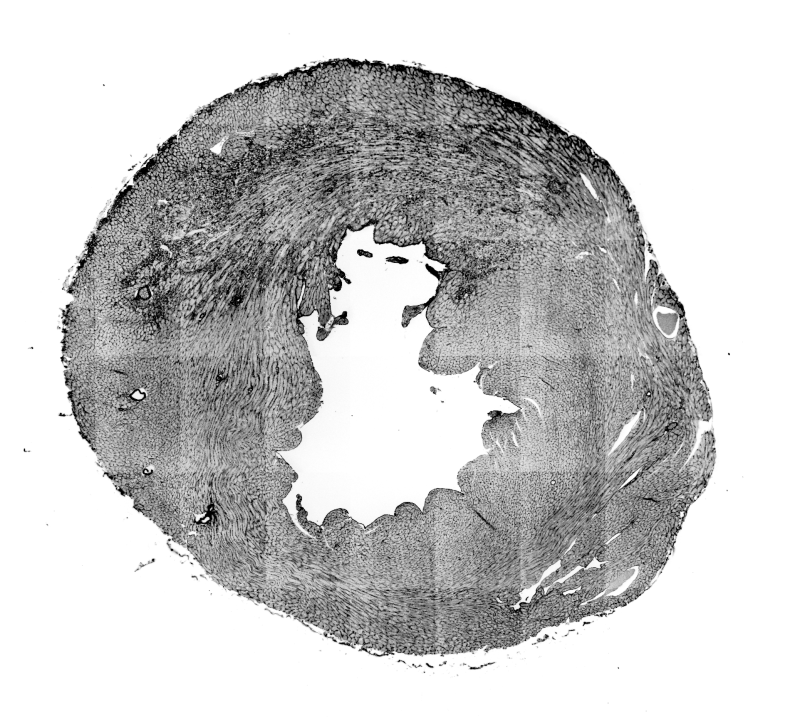

In [7]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(frame_rescaled[::SUBSAMPLE,::SUBSAMPLE],cmap="Greys")
axs.set_axis_off()

## Segmentation

In [8]:
pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,2048,2048])

2024-04-29 11:23:10,977 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 64/64 [00:30<00:00,  2.12it/s]


In [9]:
pred_masked = pred[0,:,:]
pred_masked[img < 1200] = 0

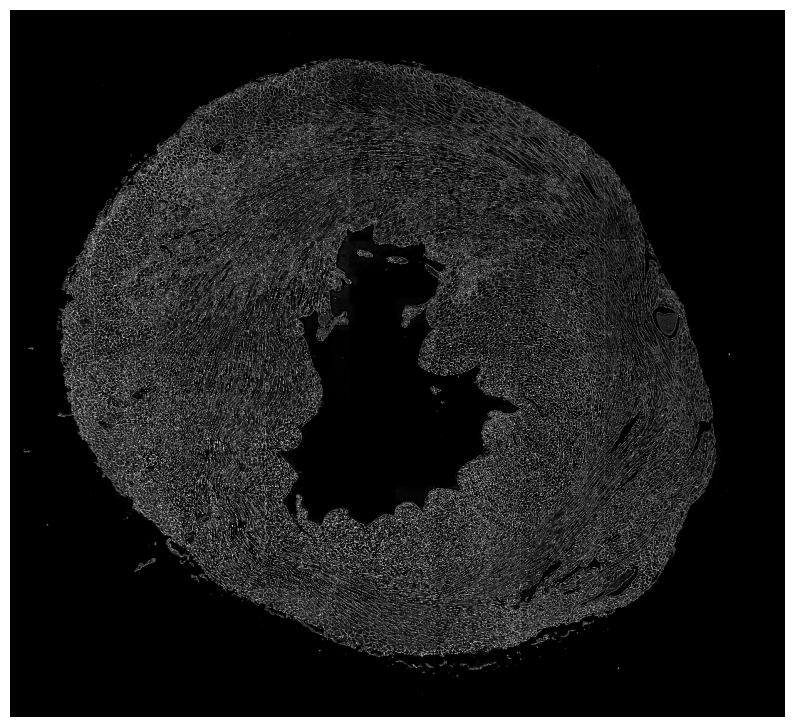

In [10]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(pred_masked[::SUBSAMPLE,::SUBSAMPLE],cmap="gray",vmin=0,vmax=1)
axs.set_axis_off()

## GASP (Generalized Algorithm for Signed Graph Partitioning) Segmentation with CNN prediction probabilities
Plantseg implements the [GASP](https://arxiv.org/abs/1906.11713) algorithm from [elf.segmentation](https://github.com/constantinpape/elf/blob/master/elf/segmentation/gasp.py) for the boundary based segmentation over CNN probabilistic outcomes.

In [47]:
label_avg = gasp(
    boundary_pmaps=pred,
    superpixels=None,
    gasp_linkage_criteria="average",
    beta=0.9,
    post_minsize=90,
    n_threads=multiprocessing.cpu_count()
    )

In [48]:
label_mutexws = gasp(
    boundary_pmaps=pred,
    superpixels=None,
    gasp_linkage_criteria='mutex_watershed',
    beta=0.9,
    post_minsize=90,
    n_threads=multiprocessing.cpu_count()
    )

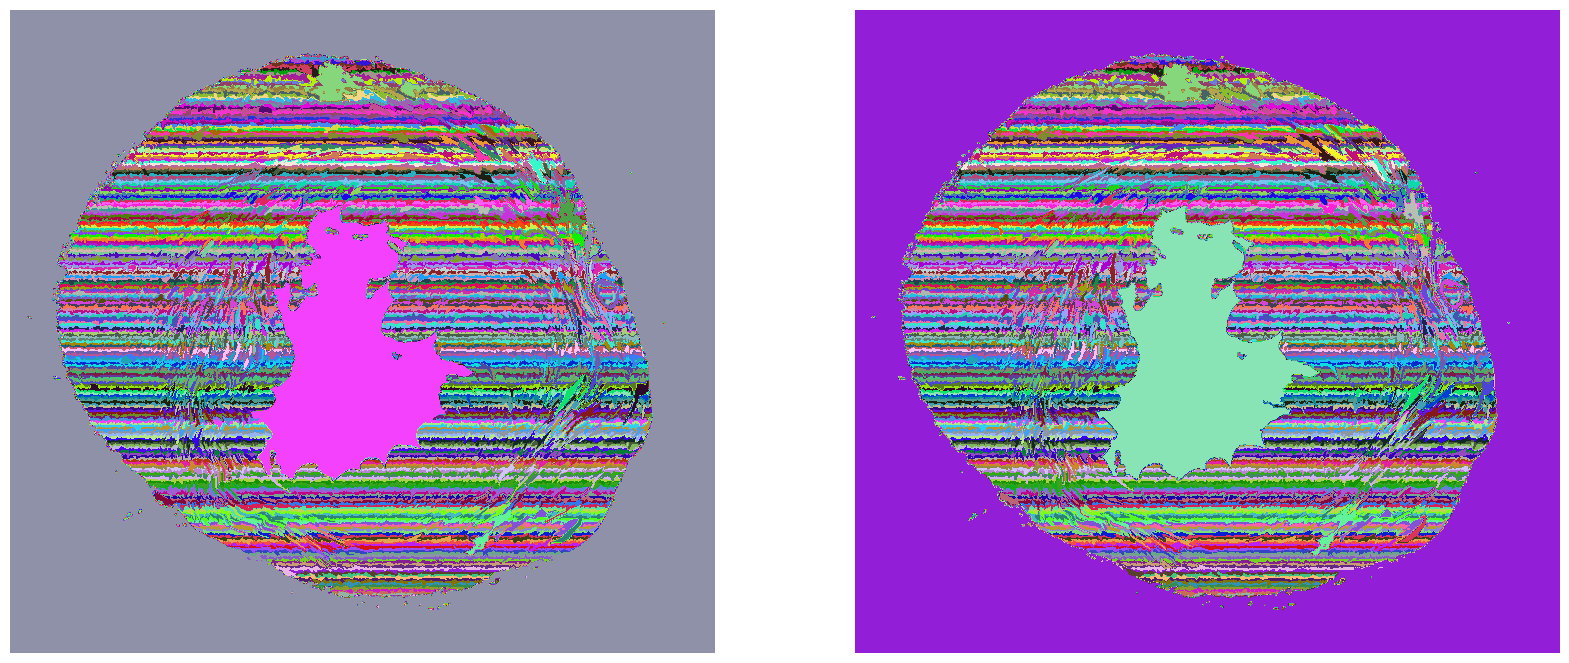

In [74]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].imshow(label_avg[0,::SUBSAMPLE,::SUBSAMPLE],cmap=cmap)
axs[0].set_axis_off()
axs[1].imshow(label_mutexws[0,::SUBSAMPLE,::SUBSAMPLE],cmap=cmap)
axs[1].set_axis_off()

In [75]:
outlines = utils.masks_to_outlines(label_mutexws[0])
outX, outY = np.nonzero(outlines)
img0 = image_to_rgb(frame_rescaled, channels=[0,0])
imgout= img0.copy()
imgout[outX, outY] = np.array([255,0,0]) # pure red

(-0.5, 1236.5, 1128.5, -0.5)

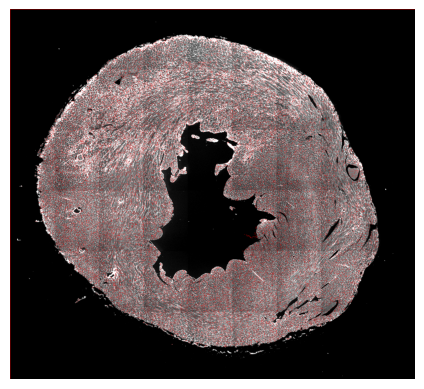

In [78]:
plt.imshow(imgout[::SUBSAMPLE,::SUBSAMPLE])
plt.axis("off")

## Output

In [87]:
out_dir = "../output"
os.makedirs(out_dir,exist_ok=True)
pps = img_aics.physical_pixel_sizes
io.pyramidal_ome_tiff_write(label_mutexws[0].astype(np.uint16).T[:,:,np.newaxis], os.path.join(out_dir,"mask_relab.ome.tif"), resX=pps.X, resY=pps.Y)
io.pyramidal_ome_tiff_write(np.transpose(imgout,(1,0,2)).astype(np.uint8), os.path.join(out_dir,"overlay.ome.tif"), resX=pps.X, resY=pps.Y)


Writing pyramidal OME TIFF: 100%|██████████| 100/100 [00:06<00:00, 16.28Percent/s]
